# Imports Necessary Modules

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import cv2
import numpy as np
import tensorflow as tf
from random import sample
from os import mkdir, listdir
from collections import Counter
import matplotlib.pyplot as plt
from shutil import copyfile, rmtree
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense ,Dropout
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay


# Function for Loading and Preprocess Images

In [2]:
target_size = (1300, 650)



def load_images_from_directory(directory, target_size):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if not os.path.isdir(label_path):
            continue
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) 
            if image is None:
                continue  
            image = cv2.resize(image, target_size)  
            image = image / 255.0  
            images.append(image)
            labels.append(label)
    images = np.array(images).reshape(-1, target_size[0], target_size[1], 1)  
    return images, labels

# Data Paths

In [3]:
train_dir = "C:\\Users\\DELL 5540\\Desktop\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\train"
valid_dir = "C:\\Users\\DELL 5540\\Desktop\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\val"
test_dir = "C:\\Users\\DELL 5540\\Desktop\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\test"

# Loading and Preprocessing Image Data for Training, Validation, and Testing Sets

In [4]:
train_images, train_labels = load_images_from_directory(train_dir, target_size)
valid_images, valid_labels = load_images_from_directory(valid_dir, target_size)
test_images, test_labels = load_images_from_directory(test_dir, target_size)

# Displaying Randomly Selected Images with Labels

Displaying images from the training set:


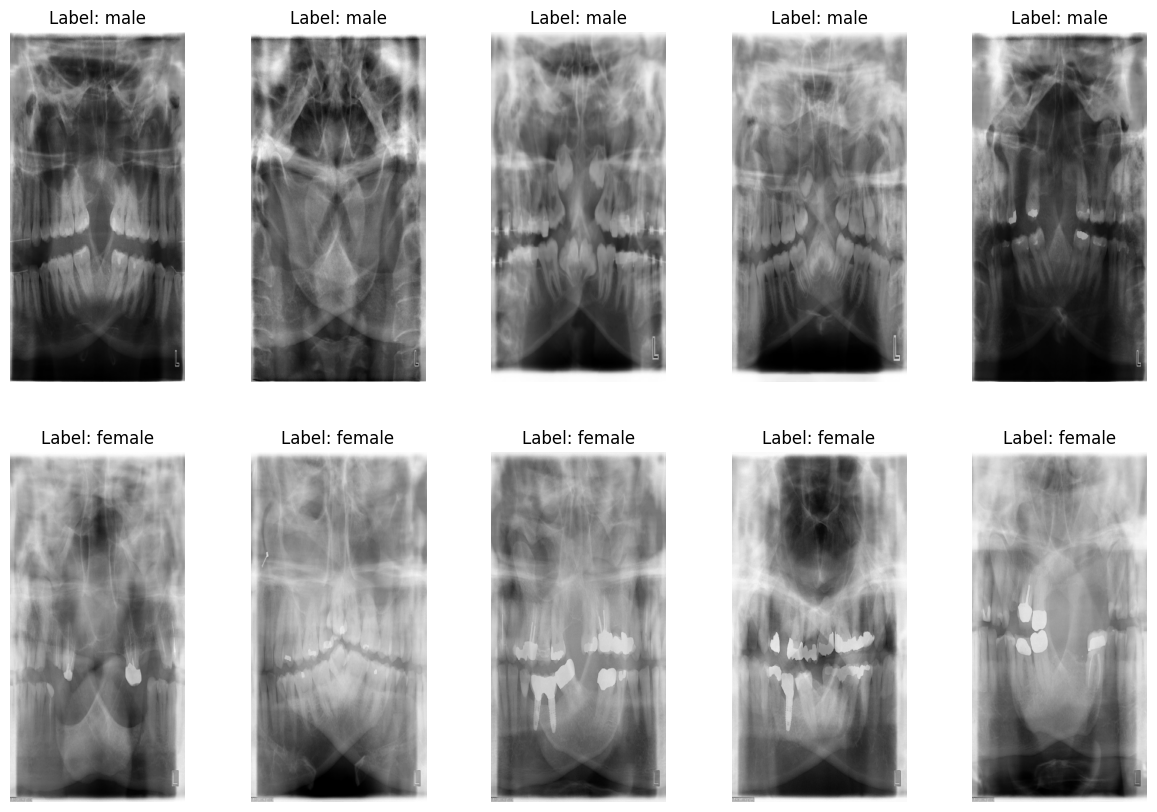

In [5]:
def display_images(images, labels, num_images=5):
    unique_labels = list(set(labels)) 
    fig, axes = plt.subplots(len(unique_labels), num_images, figsize=(15, len(unique_labels) * 5))
    for i, label in enumerate(unique_labels):
        label_images = [img for img, lbl in zip(images, labels) if lbl == label]
        for j in range(num_images):
            if j < len(label_images):
                ax = axes[i, j]
                ax.imshow(label_images[j].reshape(target_size[0], target_size[1]), cmap='gray', vmin=0, vmax=1)
                ax.set_title(f"Label: {label}")
                ax.axis('off')
            else:
                axes[i, j].axis('off')
    plt.show()
print("Displaying images from the training set:")
display_images(train_images, train_labels)


# Data Information

In [6]:
print(f"Number of training images: {len(train_images)}")
print(f"Shape of training images: {train_images.shape}")
print(f"Number of validation images: {len(valid_images)}")
print(f"Shape of validation images: {valid_images.shape}")
print(f"Number of test images: {len(test_images)}")
print(f"Shape of test images: {test_images.shape}")
print(f"Sample training labels: {train_labels[:10]}")

Number of training images: 686
Shape of training images: (686, 1300, 650, 1)
Number of validation images: 196
Shape of validation images: (196, 1300, 650, 1)
Number of test images: 97
Shape of test images: (97, 1300, 650, 1)
Sample training labels: ['female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female']


# Encoding Labels Using LabelEncode

In [7]:
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
valid_labels = label_encoder.transform(valid_labels)
test_labels = label_encoder.transform(test_labels)

# Convert labels to numpy arrays

In [8]:
train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)
test_labels = np.array(test_labels)

# Shuffle training data

In [9]:
def shuffle_data(images, labels):
    indices = np.arange(images.shape[0])
    np.random.shuffle(indices)
    return images[indices], labels[indices]
train_images, train_labels = shuffle_data(train_images, train_labels)
print(f"Sample training labels after encoding and shuffle: {train_labels[:10]}")

Sample training labels after encoding and shuffle: [0 0 0 0 0 1 0 1 1 0]


# Number of Images in each Class (Train, Validation, Test)

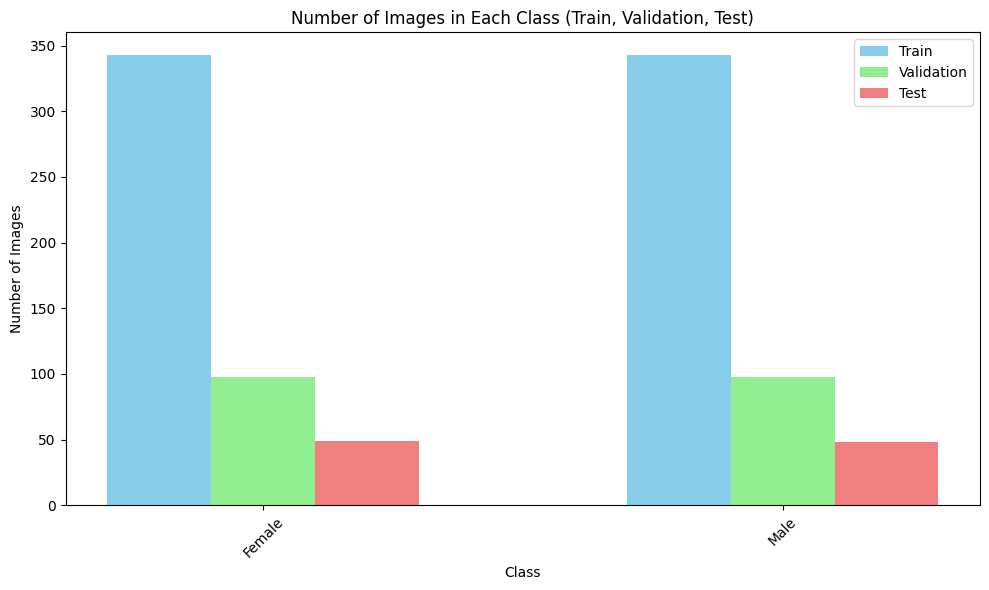

In [10]:
label_mapping = {0: 'Female', 1: 'Male'}

train_counts = Counter(train_labels)
valid_counts = Counter(valid_labels)
test_counts = Counter(test_labels)

all_classes = list(train_counts.keys())
class_names = [label_mapping[cls] for cls in all_classes]
train_values = [train_counts.get(cls, 0) for cls in all_classes]
valid_values = [valid_counts.get(cls, 0) for cls in all_classes]
test_values = [test_counts.get(cls, 0) for cls in all_classes]

x = np.arange(len(all_classes)) 
width = 0.2 
plt.figure(figsize=(10, 6)) 
plt.bar(x - width, train_values, width, label='Train', color='skyblue')
plt.bar(x, valid_values, width, label='Validation', color='lightgreen')
plt.bar(x + width, test_values, width, label='Test', color='lightcoral')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class (Train, Validation, Test)')
plt.xticks(x, class_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# CNN Model

In [11]:
CNN_Model = CNN_Model = models.Sequential([
    
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(1300, 650, 1)),
    layers.MaxPooling2D(pool_size=(2,2)),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),  
    
    layers.Dense(1, activation='sigmoid')  
    
])
CNN_Model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), 
                  loss='binary_crossentropy',  
                  metrics=['accuracy'])

# Train the Model

In [12]:
CNN_Model.fit(
              train_images, 
              train_labels,
              epochs=5,    
              validation_data=(valid_images, valid_labels),
              batch_size=1
             )

Epoch 1/5
686/686 ━━━━━━━━━━━━━━━━━━━━ 1898s 3s/step - accuracy: 0.5900 - loss: 2.5077 - val_accuracy: 0.9541 - val_loss: 0.1292
Epoch 2/5
686/686 ━━━━━━━━━━━━━━━━━━━━ 2060s 3s/step - accuracy: 0.8658 - loss: 0.3766 - val_accuracy: 0.9592 - val_loss: 0.1080
Epoch 3/5
686/686 ━━━━━━━━━━━━━━━━━━━━ 2033s 3s/step - accuracy: 0.9359 - loss: 0.2142 - val_accuracy: 0.9439 - val_loss: 0.1352
Epoch 4/5
686/686 ━━━━━━━━━━━━━━━━━━━━ 2000s 3s/step - accuracy: 0.9175 - loss: 0.2180 - val_accuracy: 0.9439 - val_loss: 0.2687
Epoch 5/5
686/686 ━━━━━━━━━━━━━━━━━━━━ 1789s 3s/step - accuracy: 0.9209 - loss: 0.2050 - val_accuracy: 0.9541 - val_loss: 0.1860


# Model Summary

In [13]:
CNN_Model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1298, 648, 32)  │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 649, 324, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 647, 322, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 323, 161, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3328192)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │   213,004,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 426,050,564 (1.59 GB)

 Trainable params: 213,025,281 (812.63 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 213,025,283 (812.63 MB)

# Saving the Model

In [14]:
CNN_Model.save('my_CNN_Gender_model.h5')

#  Evaluating the Model Performance

In [15]:
test_loss, test_accuracy = CNN_Model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.9502 - loss: 0.4642
Test Accuracy: 95.88%


# Classification Report

In [ ]:
y_pred_probs = CNN_Model.predict(test_images)
y_pred_labels = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_labels  
class_labels = ['Female', 'Male']
print("Classification Report:")
print(classification_report(y_true, y_pred_labels, target_names=class_labels))

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step
Classification Report:
              precision    recall  f1-score   support

      Female       1.00      0.92      0.96        49
        Male       0.92      1.00      0.96        48

    accuracy                           0.96        97
   macro avg       0.96      0.96      0.96        97
weighted avg       0.96      0.96      0.96        97



# Confusion Matrix

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step


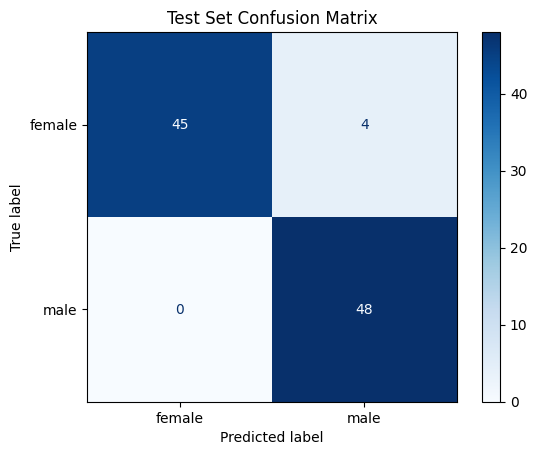

In [23]:
y_test_pred_probs = CNN_Model.predict(test_images)
y_test_pred_labels = (y_test_pred_probs > 0.5).astype(int).flatten() 
test_cm = confusion_matrix(test_labels, y_test_pred_labels)
test_cm_display = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=label_encoder.classes_)
test_cm_display.plot(cmap=plt.cm.Blues)
plt.title("Test Set Confusion Matrix")
plt.show()

# Load Trained Model and Predict Gender Class from a New Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
Predicted Gender: Female


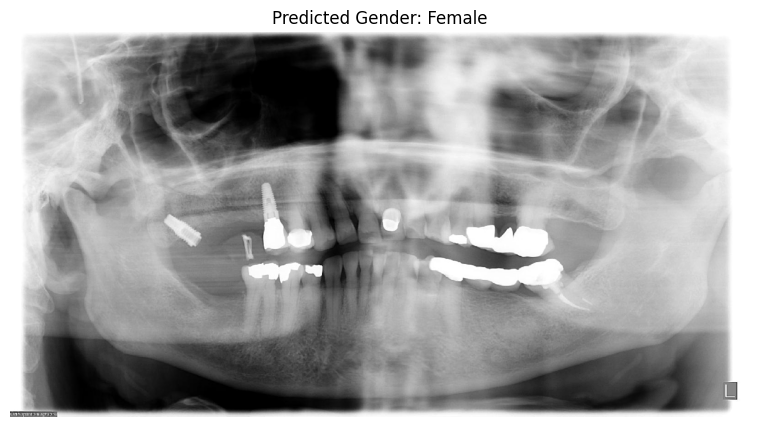

In [18]:
model = load_model('my_CNN_Gender_model.h5')
target_size = (1300, 650)
def load_and_preprocess_image(image_path, target_size):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  
    if image is None:
        raise ValueError(f"Failed to load image from {image_path}")
    image_resized = cv2.resize(image, target_size)  
    image_normalized = image_resized / 255.0  
    image_reshaped = np.expand_dims(image_normalized, axis=(0, -1))  
    return image_reshaped

image_path = 'C:\\Users\\DELL 5540\\Desktop\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\test\\female\\female.445.JPG'
image_for_prediction = load_and_preprocess_image(image_path, target_size)
prediction = model.predict(image_for_prediction)
predicted_class = np.argmax(prediction, axis=1)[0]  

class_labels = ['Female', 'Male']
print(f"Predicted Gender: {class_labels[predicted_class]}")
plt.figure(figsize=(10, 5))
plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')  
plt.title(f"Predicted Gender: {class_labels[predicted_class]}")
plt.axis('off')
plt.show()
